In [14]:
# prelims: torchtext -c pytorch; seaborn spacy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Image, display
seaborn.set_context(context="talk")
%matplotlib inline

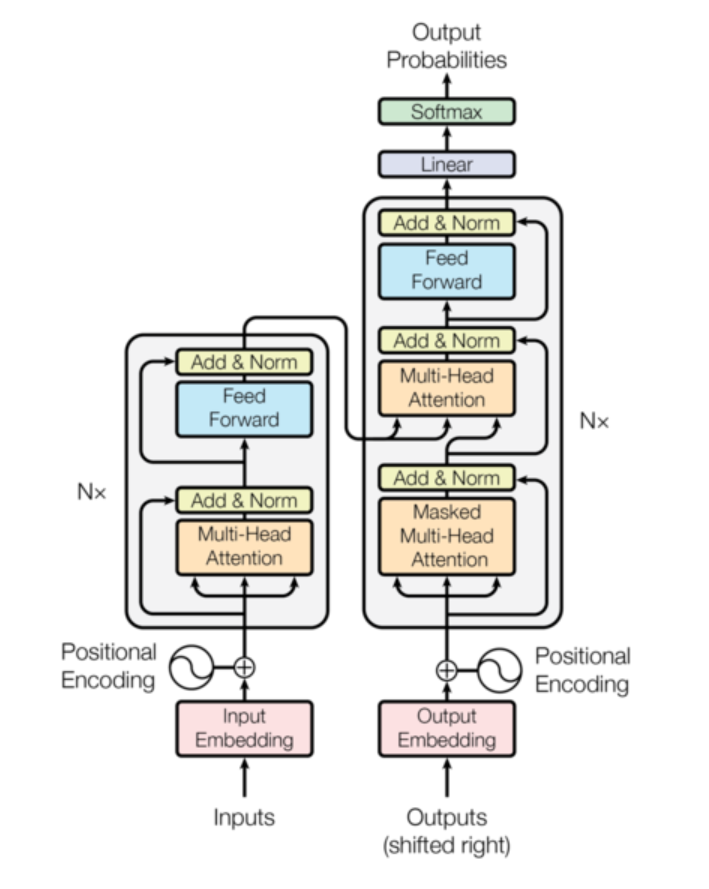

The left N layers are the encoder
The right N layers are the decoder


In [46]:
class EncoderDecoder(nn.Module):
    "A standard Encoder-Decoder architecture."
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        encoded = self.encode(src, src_mask) # n_input_features, n_hidden_features_1 ?
        decoded = self.decode(encoded, src_mask, tgt, tgt_mask)
        return decoded
    
    def encode(self, src, src_mask):
        embeded = self.src_embed(src)
        encoded = self.encoder(embeded, src_mask)
        return encoded
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        embeded = self.tgt_embed(tgt)
        decoded = self.decoder(embeded, memory, src_mask, tgt_mask)   


display(Image(filename='images/encoderDecoder.png', width=300))
print("The left N layers are the encoder\nThe right N layers are the decoder")

In [16]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        out = self.proj(x)
        out = F.log_softmax(out, dim=-1)
        return out

In [17]:
def clones(module, N):
    "Produce N identical layers."
    modules = [copy.deepcopy(module) for _ in range(N)]
    return nn.ModuleList(modules)

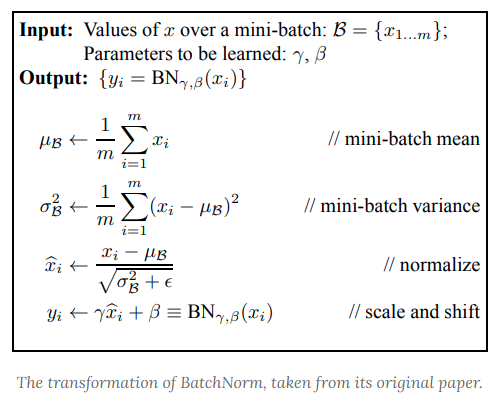

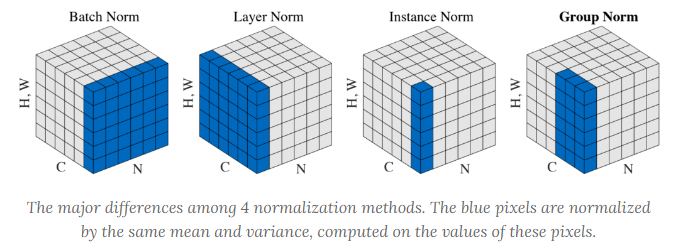

LayerNorm is like BatchNorm but in different direction


In [47]:
class LayerNorm(nn.Module):
    "Construct a layernorm module. (Vector normalization for a layer)"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features), requires_grad=True)
        self.b_2 = nn.Parameter(torch.zeros(features), requires_grad=True)
        self.eps = eps
        "a_2, b_2 are for scaling and shifting"
        "a_2 starts at 1 and b_2 starts at 0"
        "They are the norm weights to train"

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std  = x.std (-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
display(Image(filename='images/batchNorm.png', width=400))
display(Image(filename="images/norms.png", width=400))
print("LayerNorm is like BatchNorm but in different direction")

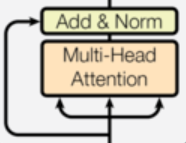

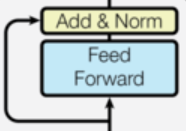

LayerNorm(x + MultiHeadAttention(x))
LayerNorm(x + FeedForward(x))


In [48]:
"""
LayerNorm is used in 4 places:
1. Residual Connection of MultiHeadAttention: LayerNorm(x + MultiHeadAttention(x))
2. Residual Connection of FeedForward: LayerNorm(x + FeedForward(x))
3. Normalization after N layers of Encoder: LayerNorm(Encoder(x))
4. Normalization after N layers of Decoder: LayerNorm(Decoder(x))
"""
display(Image(filename='images/attentionResidual.png', width=200))
display(Image(filename="images/feedResidual.png", width=200))
print("LayerNorm(x + MultiHeadAttention(x))\nLayerNorm(x + FeedForward(x))")

In [19]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        out = x
        for layer in self.layers:
            out = layer(out, mask)
        out = self.norm(out) # normalize after N layers
        return out

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm
    LayerNorm(x + dropout(Sublayer(x)))
    Sublayer can be MultiHeadAttention or FeedForward
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        out = self.norm(x) # This norm is the LayerNorm of previous sublayer
        out = sublayer(out)
        out = self.dropout(x)
        out = out + x # Residual connection
        return out

In [ ]:
class EncoderLayer(nn.Module):
    """
    Each encoder layer has 2 sub-layers
    1. self-attention
    2. feed forward
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow EncoderLayer shown on the left of the model architecture figure."
        self_attn_layer = lambda x: self._attn(x, x, x, mask) # query, key, value, mask
        out = self.sublayer[0](x,   self_attn_layer)
        out = self.sublayer[1](out, self.feed_forward)
        return out